## Test Accuracy

In [1]:
import torch.utils.data as data
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import numpy as np
import scipy.io
import os
import torch.utils.data
from collections import OrderedDict
from torch import nn

# 针对LFW测试集数据加载

class LFW(data.Dataset):
    def __init__(self, root, file_list, transform=None):
        self.root = root
        self.file_list = file_list
        self.transform = transform
        self.nameLs = []
        self.nameRs = []
        self.folds = []
        self.flags = []
        # 读取pairs文件
        with open(file_list) as f:
            pairs = f.read().splitlines()[1:]
        # 将路径存储
        for i, p in enumerate(pairs):
            p = p.split('\t')
            if len(p) == 3: # 相同
                nameL = p[0] + '/' + p[0] + '_' + '{:04}.jpg'.format(int(p[1]))
                nameR = p[0] + '/' + p[0] + '_' + '{:04}.jpg'.format(int(p[2]))
                fold = i // 600 # 分十组
                flag = 1 # 相同
            elif len(p) == 4: # 不同
                nameL = p[0] + '/' + p[0] + '_' + '{:04}.jpg'.format(int(p[1]))
                nameR = p[2] + '/' + p[2] + '_' + '{:04}.jpg'.format(int(p[3]))
                fold = i // 600
                flag = -1 # 不同
            self.nameLs.append(nameL)
            self.nameRs.append(nameR)
            self.folds.append(fold)
            self.flags.append(flag)
    def __getitem__(self, index):
        img_l = Image.open(os.path.join(self.root, self.nameLs[index])) # 读取第一张图
        img_r = Image.open(os.path.join(self.root, self.nameRs[index])) # 读取第二张图
        imglist = [img_l, img_l.transpose(Image.FLIP_LEFT_RIGHT), img_r, img_r.transpose(Image.FLIP_LEFT_RIGHT)] # 翻转拼接
        # 图片预处理
        if self.transform is not None:
            for i in range(len(imglist)):
                imglist[i] = self.transform(imglist[i])
            imgs = imglist
            return imgs
        else:
            imgs = [torch.from_numpy(i) for i in imglist]
            return imgs

    def __len__(self):
        return len(self.nameLs)
    
# 求准确率
def getAccuracy(scores, flags, threshold):
    p = np.sum(scores[flags == 1] > threshold)
    n = np.sum(scores[flags == -1] < threshold)
    return 1.0 * (p + n) / len(scores)

# 0-1分成thrnum份，10000个阈值每次求准确率，去准确率最高的一个阈值
def getThreshold(scores, flags, thrNum):
    accuracys = np.zeros((thrNum + 1, 1))
    thresholds = np.arange(0, thrNum + 1) * 1.0 / thrNum
    for i in range(thrNum + 1):
        accuracys[i] = getAccuracy(scores, flags, thresholds[i])
    max_index = np.squeeze(accuracys == np.max(accuracys))
    bestThreshold = np.mean(thresholds[max_index])
    return bestThreshold

# 评估
def evaluation_10_fold(feature_path):
    ACCs = np.zeros(10)
    result = scipy.io.loadmat(feature_path)
    # 读取文件
    fold = result['fold']
    flags = result['flag']
    featureLs = result['fl']  # (6000,256)
    featureRs = result['fr']  # (6000,256)
    flags = np.squeeze(flags)
    # 得分 cos(theta)
    featureLs = featureLs / np.expand_dims(np.sqrt(np.sum(np.power(featureLs, 2), 1)), 1)
    featureRs = featureRs / np.expand_dims(np.sqrt(np.sum(np.power(featureRs, 2), 1)), 1)
    scores = np.sum(np.multiply(featureLs, featureRs), 1)
    # 得到阈值
    threshold = getThreshold(scores, flags, 10000)
    # 得到准确率
    for i in range(10):
        testFold = fold == i
        ACCs[i] = getAccuracy(scores[testFold[0]], flags[testFold[0]], threshold)
    return ACCs

# 保存特征
def getFeatureFromTorch(feature_save_dir, model, device, data_set, data_loader):
    featureLs = None
    featureRs = None
    count = 0
    for data in data_loader:
        for i in range(len(data)): # data存有四张图片
            data[i] = data[i].to(device)
        count += data[0].size(0)
        print('extracing deep features from the face pair {}...'.format(count))
        with torch.no_grad():
            res = [model(d).data.cpu().numpy() for d in data]
        featureL = np.concatenate((res[0], res[1]), 1)
        featureR = np.concatenate((res[2], res[3]), 1)
        if featureLs is None:
            featureLs = featureL
        else:
            featureLs = np.concatenate((featureLs, featureL), 0)
        if featureRs is None:
            featureRs = featureR
        else:
            featureRs = np.concatenate((featureRs, featureR), 0)
    # 保存
    result = {'fl': featureLs, 'fr': featureRs, 'fold': data_set.folds, 'flag': data_set.flags}
    scipy.io.savemat(feature_save_dir, result)
    

In [5]:
def test_Accuracy(model_path):
    data_root = r'C:\Users\123\Desktop\数据集仓库\lfw'
    file_list='./data/pairs.txt'
    feature_save_dir='./results/result_res.mat'
    mean = [0.485, 0.456, 0.406]
    std  = [0.229, 0.224, 0.225]

    data_transforms = transforms.Compose([
            transforms.ToTensor(),
                transforms.Normalize(mean=mean,std=std),
        ])
    # 加载模型2
    model=torch.load(model_path)

    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)


    lfw_dataset = LFW(data_root, file_list, transform=data_transforms)
    lfw_loader = torch.utils.data.DataLoader(lfw_dataset, batch_size=64,
                                                 shuffle=False, num_workers=0, drop_last=False)

     # 保存特征
    getFeatureFromTorch(feature_save_dir=feature_save_dir, model=model, device=device, data_set=lfw_dataset, data_loader=lfw_loader) # 保存特征
    ACCs = evaluation_10_fold(feature_save_dir) # 计算
    
    for i in range(len(ACCs)):
        print('{}    {:.2f}%'.format(i+1, ACCs[i] * 100))
    print('--------')
    print('AVE    {:.4f}%'.format(np.mean(ACCs) * 100))

In [6]:
test_Accuracy('./model/Training_1_Res_NLLLoss_2FC_200e.pt')

extracing deep features from the face pair 64...
extracing deep features from the face pair 128...
extracing deep features from the face pair 192...
extracing deep features from the face pair 256...
extracing deep features from the face pair 320...
extracing deep features from the face pair 384...
extracing deep features from the face pair 448...
extracing deep features from the face pair 512...
extracing deep features from the face pair 576...
extracing deep features from the face pair 640...
extracing deep features from the face pair 704...
extracing deep features from the face pair 768...
extracing deep features from the face pair 832...
extracing deep features from the face pair 896...
extracing deep features from the face pair 960...
extracing deep features from the face pair 1024...
extracing deep features from the face pair 1088...
extracing deep features from the face pair 1152...
extracing deep features from the face pair 1216...
extracing deep features from the face pair 1280

In [7]:
test_Accuracy('./model/Training_2_Res_NLLLoss_1FC_50e.pt')

extracing deep features from the face pair 64...
extracing deep features from the face pair 128...
extracing deep features from the face pair 192...
extracing deep features from the face pair 256...
extracing deep features from the face pair 320...
extracing deep features from the face pair 384...
extracing deep features from the face pair 448...
extracing deep features from the face pair 512...
extracing deep features from the face pair 576...
extracing deep features from the face pair 640...
extracing deep features from the face pair 704...
extracing deep features from the face pair 768...
extracing deep features from the face pair 832...
extracing deep features from the face pair 896...
extracing deep features from the face pair 960...
extracing deep features from the face pair 1024...
extracing deep features from the face pair 1088...
extracing deep features from the face pair 1152...
extracing deep features from the face pair 1216...
extracing deep features from the face pair 1280

In [8]:
test_Accuracy('./model/Training_3_Res_FocalLoss_1FC_50e.pt')

extracing deep features from the face pair 64...
extracing deep features from the face pair 128...
extracing deep features from the face pair 192...
extracing deep features from the face pair 256...
extracing deep features from the face pair 320...
extracing deep features from the face pair 384...
extracing deep features from the face pair 448...
extracing deep features from the face pair 512...
extracing deep features from the face pair 576...
extracing deep features from the face pair 640...
extracing deep features from the face pair 704...
extracing deep features from the face pair 768...
extracing deep features from the face pair 832...
extracing deep features from the face pair 896...
extracing deep features from the face pair 960...
extracing deep features from the face pair 1024...
extracing deep features from the face pair 1088...
extracing deep features from the face pair 1152...
extracing deep features from the face pair 1216...
extracing deep features from the face pair 1280

In [9]:
test_Accuracy('./model/Training_4_Res_NLLLoss_1FC_100e.pt')

extracing deep features from the face pair 64...
extracing deep features from the face pair 128...
extracing deep features from the face pair 192...
extracing deep features from the face pair 256...
extracing deep features from the face pair 320...
extracing deep features from the face pair 384...
extracing deep features from the face pair 448...
extracing deep features from the face pair 512...
extracing deep features from the face pair 576...
extracing deep features from the face pair 640...
extracing deep features from the face pair 704...
extracing deep features from the face pair 768...
extracing deep features from the face pair 832...
extracing deep features from the face pair 896...
extracing deep features from the face pair 960...
extracing deep features from the face pair 1024...
extracing deep features from the face pair 1088...
extracing deep features from the face pair 1152...
extracing deep features from the face pair 1216...
extracing deep features from the face pair 1280

In [10]:
test_Accuracy('./model/Training_5_Res_NLLLoss_1FC_100e_SP.pt')

extracing deep features from the face pair 64...
extracing deep features from the face pair 128...
extracing deep features from the face pair 192...
extracing deep features from the face pair 256...
extracing deep features from the face pair 320...
extracing deep features from the face pair 384...
extracing deep features from the face pair 448...
extracing deep features from the face pair 512...
extracing deep features from the face pair 576...
extracing deep features from the face pair 640...
extracing deep features from the face pair 704...
extracing deep features from the face pair 768...
extracing deep features from the face pair 832...
extracing deep features from the face pair 896...
extracing deep features from the face pair 960...
extracing deep features from the face pair 1024...
extracing deep features from the face pair 1088...
extracing deep features from the face pair 1152...
extracing deep features from the face pair 1216...
extracing deep features from the face pair 1280

all_model_test_accuracy：
1. model 1: 66.9333
2. model 2: 69.8000
3. model 3: 69.7167
4. model 4: 69.8000
5. model 5: 70.1500

In [37]:
all_model_test_accuracy = [66.9333, 69.8000, 69.7167, 69.8000, 70.1500]
all_model_test_accuracy = [x-65 for x in all_model_test_accuracy]

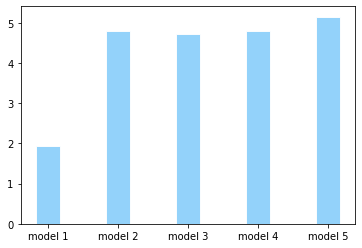

In [40]:
# -*- coding: utf-8 -*-
import matplotlib.pyplot as plt
 
num_list = all_model_test_accuracy
labels = ['model 1', 'model 2', 'model 3', 'model 4', 'model 5']




plt.bar(range(len(num_list)), num_list, alpha=0.9, width = 0.35, facecolor = 'lightskyblue', edgecolor = 'white',tick_label=labels, lw=1)
plt.show()